In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
from astropy.table import Table
from astropy.wcs import WCS

from astropy.io import fits
from astropy.table import Table
from astropy.io import ascii

import wget
import matplotlib.image as mpimg

from scipy.stats import scoreatpercentile
from astropy.visualization import simple_norm

In [2]:
homedir = os.getenv("HOME")

vfmain = Table.read(homedir+'/github/research/sample_main.fits')

In [3]:
#downloaded files will appear in this directory
os.chdir(homedir+'/github/WISE_test')

### For a test fits image cutout.fits pulled from the Legacy Survey Viewer, extract the rgb arrays and stack to form a color image.

In [4]:
image, h = fits.getdata(homedir+'/github/WISE_test/cutout.fits',header=True)

In [5]:
r=image[0]
g=image[1]
b=image[2]

rgb = np.dstack((r,g,b))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


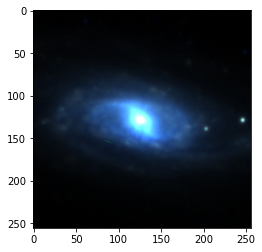

In [6]:
plt.imshow(rgb)

### I will now have a go at crafting a function that loops through vfmain (the galaxy sample) and downloads the corresponding fits images into the WISE_test directory.

In [12]:
#let number default to len(vfmain) for final product; for the moment, I use a small number for testing purposes

def pull_LS_fits(sample,number=2):
    
    for i in range(0,number):
        ra = sample['RA'][i]
        dec = sample['DEC'][i]
        
        pixscale=10.00
        
        image_url = "https://www.legacysurvey.org/viewer/cutout.fits?ra="+str(ra)+"&dec="+str(dec)+"&layer=sdss&pixscale="+str(pixscale)
        
        filename = homedir+'/github/WISE_SNR_more20/LS_optical/cutout_'+ra+'_'+dec+'.fits'
        
        if os.path.exists(filename):
            os.remove(filename) # if exists, remove it directly
            wget.download(image_url, out=filename) # download it to the specific path.
            print(image)
        else:
            image = wget.download(image_url, out=filename)
            #print(image)  
        
def pull_LS_fits_one(sample,i,pixscale):
    
    ra = sample['RA'][i]
    dec = sample['DEC'][i]        
        
    image_url = "https://www.legacysurvey.org/viewer/cutout.fits?ra="+str(ra)+"&dec="+str(dec)+"&layer=ls-dr9&pixscale="+str(pixscale)
    
    filename = image_path = homedir+'/github/WISE_SNR_more20/LS_optical/cutout_'+str(ra)+'_'+str(dec)+'.fits'
        
    if os.path.exists(filename):
        os.remove(filename) # if exists, remove it directly
        image = wget.download(image_url, out=filename) # download it to the specific path.
        #print(image)
    else:
        image = wget.download(image_url, out=filename)
        #print(image)  
    


In [8]:
pull_LS_fits_one(vfmain,0,pixscale=10.00)

### Now create a function that displays each stacked fits image with wcs axis coordinates.

In [4]:
def display_LS_cutout(sample,i,percentile1=.5,percentile2=99.5):
    
    #if the cutout only includes ra & dec to four decimal places, remove # from second and fourth lines
    ra = sample['RA'][i]
    #ra = str("{0:.4f}".format(ra))
    dec = sample['DEC'][i]
    #dec = str("{0:.4f}".format(dec))
    
    image_path = homedir+'/github/WISE_test_two/cutout_'+str(ra)+'_'+str(dec)+'.fits'
    image, h = fits.getdata(image_path,header=True)
    
    wcs = WCS(h)
    title = 'Legacy Image'
    
    r=image[0]
    g=image[1]
    b=image[2]
    rgb = np.dstack((r,g,b))
    
    #norms = [simple_norm(r,'asinh',max_percent=percentile2),
    #       simple_norm(r,'asinh',max_percent=percentile2)]
    
    plt.figure(figsize=(14,6))
    plt.subplots_adjust(wspace=.0)
    plt.subplot(1,3,1,projection=wcs[1])
    #plt.imshow(rgb,origin='lower',norm = norms)
    plt.imshow(rgb,origin='lower')
    plt.xlabel('RA')
    plt.ylabel('DEC')
    
    ax=plt.gca()
    ax.set_yticks([])
    plt.title(title,fontsize=16)
    
    print(-1*h['NAXIS1']*h['CD1_1']*3600)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2560.0000000000023


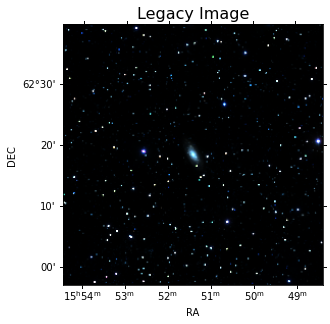

In [10]:
display_LS_cutout(vfmain,0)

### We now display the WISE image...

In [5]:
def display_WISE_cutout(sample,i,percentile1=.5,percentile2=99.5,cmap='viridis'):
    
    #the cutouts only include ra & dec to four decimal places, so
    ra = sample['RA'][i]
    dec = sample['DEC'][i]
    galname = sample['prefix'][i]
    
    image_path = homedir+'/github/WISE_test_two/'+str(galname)+'-unwise-w3-1Comp-galfit-out.fits'
    image, h = fits.getdata(image_path,1,header=True)
    
    images = [image]
    
    wcs = WCS(h)
    title = 'WISE Image'
    
    v1 = [scoreatpercentile(image,percentile1),
        scoreatpercentile(image,percentile1)]
    v2 = [scoreatpercentile(image,percentile2),
        scoreatpercentile(image,percentile2)]
    
    for i,im in enumerate(images): 
        plt.figure(figsize=(14,6))
        plt.subplots_adjust(wspace=.0)
        plt.subplot(1,3,i+1,projection=wcs)
        plt.imshow(im,origin='lower',cmap=cmap,vmin=v1[i],vmax=v2[i])
        plt.xlabel('RA')
        plt.ylabel('DEC')
        ax = plt.gca()
        ax.set_yticks([])
        plt.title(title,fontsize=16)
    
    print(-1*h['NAXIS1']*h['CD1_1']*3600)

957.0000000001392


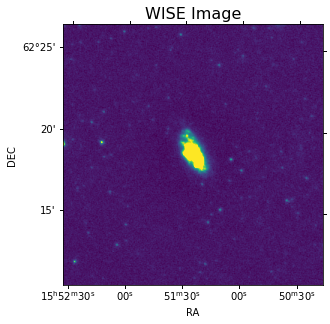

In [12]:
display_WISE_cutout(vfmain,0)

### Okie dokie! Evidently, there is an axis mismatch, as anticipated. The next task is to correct the difference such that the LS image zoom is about identical to that of the WISE image.

There are few ideas that are immediately apparent to me, but one could potentially be viable.
Both fits images contain header information, which encodes the number of arcsec each pixel represents. For instance, for RA,

NAXIS1$*$CD1_1$*3600$ = # RA arcsecs per pixel

If the values from each image are not equivalent, then we must re-grab the LS fits cutout with a different pixscale value. Alternatively, I could manipulate the LS cutout axes a bit, but doing so may be a bit more involved. 

In [13]:
#to begin, I established how the zoom values affect the # arcseconds represented by each pixel.
#essentially, I can rely strictly on RA header values for alignment purposes, since both images are square cutouts.
#print(-1*h['NAXIS1']*h['CD1_1']*3600) gives the necessary number; and each pixscale + 1 gives + 256 to the printed 
#value.

#pixscale --> value
#   1     -->  256
#   2     -->  512
#   3     -->  768
#   4     --> 1024
#   5     --> 1280
#   6     --> 1536

#and so forth.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1023.999999999999
957.0000000001392


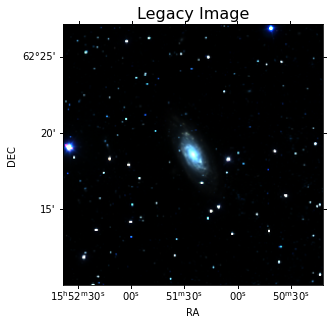

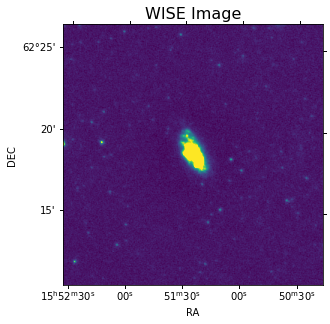

In [14]:
pull_LS_fits_one(vfmain,0,4)

display_LS_cutout(vfmain,0)
display_WISE_cutout(vfmain,0)

#note: pixscale = 3.5 gives a value nearer to 957; however, 4 is sufficiently close.

### NEXT, I aim to automate this process AND display the two images horizontally, not vertically.

In [6]:
def align_fits_one(sample,i,initial_pixscale,percentile1=.5,percentile2=99.5,cmap='viridis'):

    
    #ra, dec, galname
    ra = sample['RA'][i]
    dec = sample['DEC'][i]
    galname = sample['prefix'][i]
    
    #define the images and their respective header information
    
    #WISE
    try:
        image_path = homedir+'/github/WISE_test_two/'+str(galname)+'-unwise-w3-1Comp-galfit-out.fits'
        image_WISE, h_WISE = fits.getdata(image_path,1,header=True)
        
        wcs_WISE = WCS(h_WISE)
    
        v1 = [scoreatpercentile(image_WISE,percentile1),
            scoreatpercentile(image_WISE,percentile1)]
        v2 = [scoreatpercentile(image_WISE,percentile2),
            scoreatpercentile(image_WISE,percentile2)]
    
        #LS    
        pull_LS_fits_one(vfmain,i,initial_pixscale)
        image_path = homedir+'/github/WISE_test_two/cutout_'+str(ra)+'_'+str(dec)+'.fits'
        image_LS, h_LS = fits.getdata(image_path,header=True)
    
        #This loop will filter the scale value that aligns the images...
        #note: be sure that the range is large enough to accommodate a, well, range of potential pixscale values
        
        for scale in np.arange(1,12.5,0.2):

            if (h_WISE['NAXIS1']*h_WISE['CD1_1']/(h_LS['NAXIS1']*h_LS['CD1_1']) > 0.90)&(h_WISE['NAXIS1']*h_WISE['CD1_1']/(h_LS['NAXIS1']*h_LS['CD1_1']) < 1.10):
                pixscales.append(scale)
                print('complete: pixscale',scale)
                print('ratio',h_WISE['NAXIS1']*h_WISE['CD1_1']/(h_LS['NAXIS1']*h_LS['CD1_1']))
                break
            else:
                #print('scale tried:',scale)
                #print('ratio',h_WISE['NAXIS1']*h_WISE['CD1_1']/(h_LS['NAXIS1']*h_LS['CD1_1']))
                pull_LS_fits_one(vfmain,i,scale)
                image_LS, h_LS = fits.getdata(image_path,header=True)
                
                
        wcs_LS = WCS(h_LS)
    
        r=image_LS[0]
        g=image_LS[1]
        b=image_LS[2]
        rgb_LS = np.dstack((r,g,b))
        image_LS = rgb_LS
    
        images = [image_WISE,image_LS]
        titles = ['WISE Image','Legacy Image']
        #wcs = [wcs_WISE, wcs_LS]
    
        #create loop to display images side-by-side (template from Rose's code)
    
        plt.figure(figsize=(14,6))
        plt.subplots_adjust(wspace=.0)
        for i,im in enumerate(images): 

        
            plt.xlabel('RA')
            if i == 0:
                plt.subplot(1,3,i+1,projection=wcs_WISE)
                plt.imshow(im,origin='lower',cmap=cmap,vmin=v1[i],vmax=v2[i])
                plt.ylabel('DEC')
            if i == 1:
                plt.subplot(1,3,i+1,projection=wcs_LS[1])
                plt.imshow(im,origin='lower')
                ax = plt.gca()
                ax.set_yticks([])
        
            plt.title(titles[i],fontsize=16)
            
            #print('ratio',h_WISE['NAXIS1']*h_WISE['CD1_1']/(h_LS['NAXIS1']*h_LS['CD1_1']))
    except:
        pixscales.append(-999)
        pass
    
    #print(-1*h_WISE['NAXIS1']*h_WISE['CD1_1']*3600)
    #print(-1*h_LS['NAXIS1']*h_LS['CD1_1']*3600)
    #print(pixscales)
    

scale tried: 3.0
ratio 2.424153645833687
scale tried: 3.5
ratio 2.424153645833687
scale tried: 4.0
ratio 2.0778459821431596
scale tried: 4.5
ratio 1.818115234375266
scale tried: 5.0
ratio 1.6161024305557905
scale tried: 5.5
ratio 1.4544921875002101
scale tried: 6.0
ratio 1.3222656250001903
scale tried: 6.5
ratio 1.2120768229168404
scale tried: 7.0
ratio 1.118840144230929


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


complete: pixscale 7.5
ratio 1.038922991071582


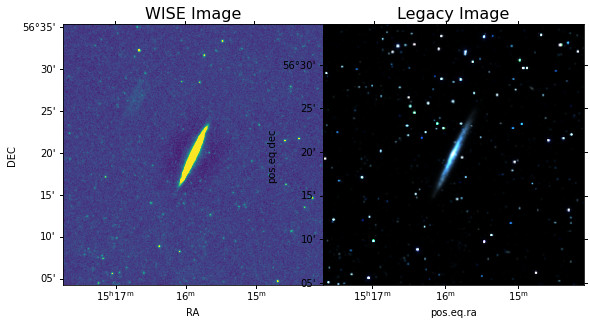

In [34]:
#testing on one galaxy

pixscales=[]
align_fits_one(vfmain,4,3)

In [ ]:
#testing on ALL THE GALAXIES! MWUHAHAHAHAHA.

pixscales=[]
for i in range(0,len(vfmain)):
    align_fits_one(vfmain,i,2)
    filename = homedir+'/github/WISE_test/mosaic'+str(i)+'.png'
        
    if os.path.exists(filename):
        os.remove(filename) # if exists, remove it directly
        plt.savefig('mosaic%s.png'%i)
    else:
        plt.savefig('mosaic%s.png'%i)

    plt.close()
print(pixscales)

In [38]:
#lastly, check that the number of pixscale elements match that of the vfmain sample (if not, the pixscale range
#in the function loop may not have been sufficiently encompassing).

len(pixscales)

59

# #fin

In [6]:
homedir = os.getenv("HOME")

vfmain = Table.read(homedir+'/github/research/sample_main_two.fits')

#downloaded files will appear in this directory
os.chdir(homedir+'/github/WISE_test_two')

In [ ]:
pixscales=[]


for i in range(0,len(vfmain)):
    print(i)
    align_fits_one(vfmain,i,1)
    filename = homedir+'/github/WISE_test_two/'+str(vfmain['VFID'][i])+'-mosaic.png'
        
    if os.path.exists(filename):
        os.remove(filename) # if exists, remove it directly
        plt.savefig('%s-mosaic.png'%vfmain['VFID'][i])
    else:
        plt.savefig('%s-mosaic.png'%vfmain['VFID'][i])

    plt.close()
    
print(pixscales)
print(len(pixscales))

In [10]:
print(len(pixscales))
print(len(vfmain))

232
232


In [17]:
pixscales_rounded = []
for number in pixscales:
    pixscales_rounded.append(round(number,1))

In [21]:
print(pixscales_rounded)

[2.2, 2.2, 2.0, 2.4, 2.2, 2.4, 2.2, 2.2, 2.8, 3.8, 2.8, 2.6, 2.4, 2.6, 3.6, 3.2, 2.2, 2.8, 3.8, 2.8, 3.6, 3.6, 2.4, 2.2, 2.8, 2.8, 3.0, 2.4, 2.4, 2.6, 2.6, 2.2, 7.0, 2.4, 4.0, 5.4, 2.6, 2.6, 4.4, 2.4, 2.6, 3.0, 4.0, 3.2, 2.6, 4.4, 3.0, 3.6, 4.2, 3.0, 2.4, 2.6, 2.0, 2.4, 2.2, 3.4, 3.6, 2.0, 2.4, 3.6, 3.8, 2.2, 2.8, 2.6, 4.0, 4.0, 3.4, 3.2, 2.4, 2.8, 4.0, 7.6, 2.4, 2.6, 4.4, 2.4, 2.6, 2.6, 2.4, 3.0, 2.8, 2.4, 2.8, 2.0, 3.2, 2.4, 2.4, 4.8, 6.4, 2.2, 3.6, 2.6, 3.0, 2.4, 2.4, 2.2, 2.6, -999, 4.0, 2.8, 2.4, 2.4, 2.6, 3.8, 2.6, 6.8, 10.6, 2.8, 6.2, 4.4, 2.2, 2.6, 2.4, 7.6, 2.6, 2.8, 2.2, 4.0, 2.4, 4.6, 3.0, 3.0, 3.4, 2.2, 2.2, 2.6, 4.0, 2.8, 2.0, 2.4, 4.0, 5.6, 3.4, 2.2, 2.6, 2.8, 2.4, 2.6, 2.4, 7.0, 2.8, 2.6, 2.4, 3.0, 5.0, 2.2, 3.2, 6.6, 3.2, 3.4, 3.4, 3.2, 4.6, 5.2, 3.2, 2.6, 2.6, 4.6, 4.4, 2.4, 2.2, 2.2, 2.4, 2.8, 3.0, 2.4, 3.6, 2.8, 2.4, 2.2, 3.0, 2.2, 2.2, 2.8, 2.4, 2.4, 2.6, 2.6, 5.4, 6.2, 3.2, 2.6, 2.8, 2.8, 2.2, 2.4, 2.4, 2.8, 2.8, 2.6, 2.0, 2.6, 4.4, 2.4, 2.4, 2.2, 3.6, 3.0, 3.0, 2.

In [13]:
#pull one fits cutout from the Legacy Survey Viewer; sample, index, corresponding pixscale (dictates zoom)

def pull_LS_fits_one(sample,i,pixscale):
    
    #define ra, dec of sample
    ra = sample['RA'][i]
    dec = sample['DEC'][i]        
    
    #image url template from which to grab LS fits image (necessary for header information)
    image_url = "https://www.legacysurvey.org/viewer/cutout.fits?ra="+str(ra)+"&dec="+str(dec)+"&layer=ls-dr9&pixscale="+str(pixscale)
    
    #file path
    filename = homedir+'/github/WISE_SNR_less20/LS_optical/cutout_'+str(ra)+'_'+str(dec)+'.fits'
    
    #if file path exists, overwrite...otherwise, directly wget source
    if os.path.exists(filename):
        os.remove(filename) # if exists, remove it directly
        image = wget.download(image_url, out=filename) # download it to the specific path.
        #print(image)
    else:
        image = wget.download(image_url, out=filename)
        #print(image) 

In [14]:
#unWISE SNR<20
homedir = os.getenv("HOME")
os.chdir(homedir+'/github/WISE_SNR_less20')
vfmain = Table.read('vfmain_less.fits')

In [15]:
def align_fits_snr(sample,i,initial_pixscale,percentile1=.5,percentile2=99.5,cmap='viridis'):
    
    #ra, dec, galname
    ra = sample['RA'][i]
    dec = sample['DEC'][i]
    galname = sample['VFID'][i]
    
    #define the images and their respective header information 
    #prior to doing so, run LINUX script (see meetingnotes)

    image_path = homedir+'/github/WISE_SNR_less20/figures_less_fits/'+str(galname)
    image_WISE, h_WISE = fits.getdata(image_path,header=True)
        
    wcs_WISE = WCS(h_WISE)
    
    #for scaling the WISE image cutout
    v1 = [scoreatpercentile(image_WISE,percentile1),
            scoreatpercentile(image_WISE,percentile1)]
    v2 = [scoreatpercentile(image_WISE,percentile2),
            scoreatpercentile(image_WISE,percentile2)]
    
    #LS (fits image with header information) 
    pull_LS_fits_one(sample,i,initial_pixscale)
    image_path = homedir+'/github/WISE_SNR_less20/LS_optical/cutout_'+str(ra)+'_'+str(dec)+'.fits'
    image_LS, h_LS = fits.getdata(image_path,header=True)
    
    
    
    #This loop will filter the scale value that aligns the images...
    #note: be sure that the range is large enough to accommodate a, well, range of potential pixscale values   
    for scale in np.arange(0.05,10,0.01):

        if (h_WISE['NAXIS1']*h_WISE['CD1_1']/(h_LS['NAXIS1']*h_LS['CD1_1']) > 0.97)&(h_WISE['NAXIS1']*h_WISE['CD1_1']/(h_LS['NAXIS1']*h_LS['CD1_1']) < 1.03):
            pixscales.append(scale)
            scale=scale
            print('complete: pixscale',scale)
            print('ratio',h_WISE['NAXIS1']*h_WISE['CD1_1']/(h_LS['NAXIS1']*h_LS['CD1_1']))
            break
        else:
            pull_LS_fits_one(sample,i,scale)
            image_LS, h_LS = fits.getdata(image_path,header=True)
    
    wcs_LS = WCS(h_LS)

    #annnnnnnnd, pull the jpg image
    image_url = "https://www.legacysurvey.org/viewer/cutout.jpg?ra="+str(sample['RA'][i])+"&dec="+str(sample['DEC'][i])+"&layer=ls-dr9&pixscale="+str(scale)
    ls_jpg = wget.download(image_url)
    #change filename to a more identifiable version
    image_desired = "cutout"+str(sample['prefix'][i])+".jpg"
    #print(image_desired)
    os.rename(ls_jpg,image_desired)
    ls_jpg = image_desired    

    
    
    images = [image_WISE,image_LS,ls_jpg]
    titles = ['WISE Image','LS fits','LS jpg']    
    
    
    plt.figure(figsize=(14,6))
    plt.subplots_adjust(wspace=.0)
    for i,im in enumerate(images): 

        
            plt.xlabel('RA')
            if i == 0:
                plt.subplot(1,3,i+1,projection=wcs_WISE)
                plt.imshow(im,origin='lower',cmap=cmap,vmin=v1[i],vmax=v2[i])
                plt.ylabel('DEC')
                ax = plt.gca()
                ax.set_yticks([])
            if i == 1:
                 plt.subplot(1,3,i+1,projection=wcs_LS[1])
            #    plt.subplot(1,3,i+1)

            #    im_norm= abs(im/np.max(im))*255
            #    plt.imshow(im_norm,origin='lower')
            #    print(np.min(im_norm))
            #    print(np.max(im_norm))                
            if i == 2:
                plt.imshow(mpimg.imread(ls_jpg),origin='lower')
                plt.gca().invert_yaxis()
                plt.axis("off")
                #ax = plt.gca()
                #ax.set_yticks([])
        
            plt.title(titles[i],fontsize=16)
            

complete: pixscale 0.5200000000000001
ratio 1.0110294117648504


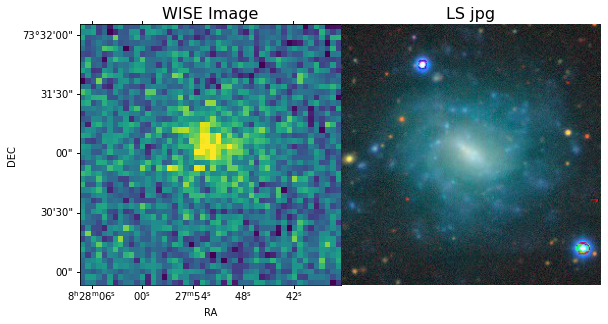

In [17]:
#the test cell
os.mkdir('LS_optical')
align_fits_snr(vfmain,0,0.1)

In [20]:
pixscales = []

#os.mkdir(LS_optical)

for i in range(0,31):
        if (vfmain['VFID'][i] != vfmain['VFID'][8]) & (vfmain['VFID'][i] != vfmain['VFID'][28]):
            print(i)
            align_fits_snr(vfmain,i,0.1)
            filename = homedir+'/github/WISE_SNR_less20/LS_optical/'+str(vfmain['VFID'][i])+'-mosaic.png'
        
            if os.path.exists(filename):
                os.remove(filename) # if exists, remove it directly
                plt.savefig('%s-mosaic.png'%vfmain['VFID'][i])
            else:
                plt.savefig('%s-mosaic.png'%vfmain['VFID'][i])

            plt.close()
        else:
            pass
print(pixscales)

0
complete: pixscale 0.5200000000000001
ratio 1.0110294117648504


1
complete: pixscale 0.21000000000000002
ratio 1.0205078125001477


2
complete: pixscale 0.7300000000000002
ratio 1.0294596354168164


3
complete: pixscale 0.7000000000000002
ratio 1.0275135869566694


4
complete: pixscale 0.6100000000000001
ratio 1.020507812500146


5
complete: pixscale 0.32000000000000006
ratio 1.004914314516275


6
complete: pixscale 0.37000000000000005
ratio 1.014539930555703


7
complete: pixscale 0.6800000000000002
ratio 1.0261194029852245


9
complete: pixscale 0.37000000000000005
ratio 1.014539930555703


10
complete: pixscale 0.7900000000000001
ratio 1.0191306089745056


11
complete: pixscale 0.39000000000000007
ratio 1.0176809210527753


12
complete: pixscale 0.5200000000000001
ratio 1.0110294117648504


13
complete: pixscale 0.39000000000000007
ratio 1.0176809210527753


14
complete: pixscale 0.4700000000000001
ratio 1.0275135869566692


15
complete: pixscale 0.8100000000000002
ratio 1.0205078125001494


16
complete: pixscale 0.6900000000000002
ratio 1.0268267463236782


17
complete: pixscale 0.7700000000000002
ratio 1.01768092105278


18
complete: pixscale 0.35000000000000003
ratio 1.0110294117648524


19
complete: pixscale 0.5100000000000001
ratio 1.0097656250001459


20
complete: pixscale 0.23000000000000004
ratio 1.0253906250001492


21
complete: pixscale 0.49000000000000005
ratio 1.029459635416819


22
complete: pixscale 0.4600000000000001
ratio 1.0264756944445936


23
complete: pixscale 0.7600000000000002
ratio 1.016927083333483


24
complete: pixscale 0.6100000000000001
ratio 1.020507812500146


25
complete: pixscale 0.5900000000000002
ratio 1.0186557112070453


26
complete: pixscale 0.4000000000000001
ratio 1.0191306089745102


27
complete: pixscale 0.32000000000000006
ratio 1.004914314516275


29
complete: pixscale 0.5300000000000001
ratio 1.012244591346304


IndexError: index 30 is out of bounds for axis 0 with size 30

In [21]:
len(vfmain)

30

In [ ]:
#ROUTINE FOR SNR>20 CUTOUTS

In [30]:
def pull_LS_fits_one(sample,i,pixscale):
    
    ra = sample['RA'][i]
    dec = sample['DEC'][i]        
        
    image_url = "https://www.legacysurvey.org/viewer/cutout.fits?ra="+str(ra)+"&dec="+str(dec)+"&layer=ls-dr9&pixscale="+str(pixscale)
    
    filename = homedir+'/github/WISE_SNR_more20/LS_optical/cutout_'+str(ra)+'_'+str(dec)+'.fits'
        
    if os.path.exists(filename):
        os.remove(filename) # if exists, remove it directly
        image = wget.download(image_url, out=filename) # download it to the specific path.
        #print(image)
    else:
        image = wget.download(image_url, out=filename)
        #print(image) 

In [31]:
#SNR>20
homedir = os.getenv("HOME")
os.chdir(homedir+'/github/WISE_SNR_more20')
vfmain = Table.read(homedir+'/github/WISE_SNR_more20/vfmain_more.fits')

In [32]:
def align_fits_snr2(sample,i,initial_pixscale,percentile1=.5,percentile2=99.5,cmap='viridis'):
    
    #ra, dec, galname
    ra = sample['RA'][i]
    dec = sample['DEC'][i]
    galname = sample['VFID'][i]
    
    #define the images and their respective header information 

    image_path = homedir+'/github/WISE_SNR_more20/figures_more_fits/'+str(galname)
    image_WISE, h_WISE = fits.getdata(image_path,header=True)
        
    wcs_WISE = WCS(h_WISE)
    
    #for scaling the WISE image cutout
    v1 = [scoreatpercentile(image_WISE,percentile1),
            scoreatpercentile(image_WISE,percentile1)]
    v2 = [scoreatpercentile(image_WISE,percentile2),
            scoreatpercentile(image_WISE,percentile2)]
    
    #LS (fits image with header information) 
    pull_LS_fits_one(sample,i,initial_pixscale)
    image_path = homedir+'/github/WISE_SNR_more20/LS_optical/cutout_'+str(ra)+'_'+str(dec)+'.fits'
    image_LS, h_LS = fits.getdata(image_path,header=True)
    
    
    
    #This loop will filter the scale value that aligns the images...
    #note: be sure that the range is large enough to accommodate a, well, range of potential pixscale values   
    for scale in np.arange(0.05,10,0.01):

        if (h_WISE['NAXIS1']*h_WISE['CD1_1']/(h_LS['NAXIS1']*h_LS['CD1_1']) > 0.97)&(h_WISE['NAXIS1']*h_WISE['CD1_1']/(h_LS['NAXIS1']*h_LS['CD1_1']) < 1.03):
            pixscales.append(scale)
            scale=scale
            print('complete: pixscale',scale)
            print('ratio',h_WISE['NAXIS1']*h_WISE['CD1_1']/(h_LS['NAXIS1']*h_LS['CD1_1']))
            break
        else:
            pull_LS_fits_one(sample,i,scale)
            image_LS, h_LS = fits.getdata(image_path,header=True)
    
    wcs_LS = WCS(h_LS)
    
    
    #for plotting the r,g,b .fits components as a stacked image. this display idea was ultimately poo.
    #r = image_LS[0]
    #g = image_LS[1]
    #b = image_LS[2]
    #rgb_LS = np.dstack((r,g,b))
    #image_LS = rgb_LS
    
    
    #annnnnnnnd, pull the jpg image
    image_url = "https://www.legacysurvey.org/viewer/cutout.jpg?ra="+str(sample['RA'][i])+"&dec="+str(sample['DEC'][i])+"&layer=ls-dr9&pixscale="+str(scale)
    ls_jpg = wget.download(image_url)
    #change filename to a more identifiable version
    image_desired = "cutout"+str(sample['prefix'][i])+".jpg"
    #print(image_desired)
    os.rename(ls_jpg,image_desired)
    ls_jpg = image_desired    

    
    
    images = [image_WISE,image_LS,ls_jpg]
    titles = ['WISE Image','LS fits','LS jpg']    
    
    
    plt.figure(figsize=(14,6))
    plt.subplots_adjust(wspace=.0)
    for i,im in enumerate(images): 

        
            plt.xlabel('RA')
            if i == 0:
                plt.subplot(1,3,i+1,projection=wcs_WISE)
                plt.imshow(im,origin='lower',cmap=cmap,vmin=v1[i],vmax=v2[i])
                plt.ylabel('DEC')
                ax = plt.gca()
                ax.set_yticks([])
            if i == 1:
                 plt.subplot(1,3,i+1,projection=wcs_LS[1])
            #    plt.subplot(1,3,i+1)

            #    im_norm= abs(im/np.max(im))*255
            #    plt.imshow(im_norm,origin='lower')
            #    print(np.min(im_norm))
            #    print(np.max(im_norm))                
            if i == 2:
                plt.imshow(mpimg.imread(ls_jpg),origin='lower')
                plt.gca().invert_yaxis()
                plt.axis("off")
                #ax = plt.gca()
                #ax.set_yticks([])
        
            plt.title(titles[i],fontsize=16)
            

complete: pixscale 0.6500000000000001
ratio 1.0238647460938977


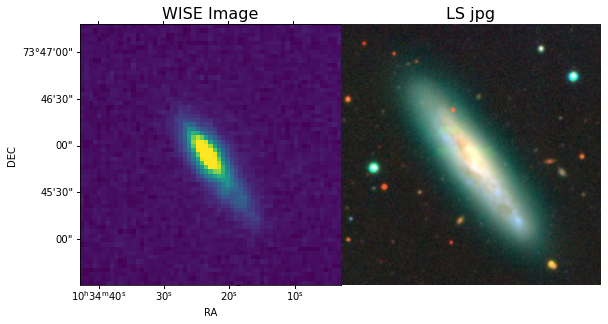

In [33]:
#the test cell
#os.mkdir('LS_optical')
for i in range(4,5):
    align_fits_snr2(vfmain,i,0.1)

In [ ]:
pixscales = []

for i in range(25,31):
    #identify 'failed' galaxy indices to exclude from loop
    if (vfmain['VFID'][i] != vfmain['VFID'][9]) & (vfmain['VFID'][i] != vfmain['VFID'][10]) & (vfmain['VFID'][i] != vfmain['VFID'][11]) & (vfmain['VFID'][i] != vfmain['VFID'][26]):
        print(i)
        align_fits_snr2(vfmain,i,0.1)
        filename = homedir+'/github/WISE_SNR_more20/LS_optical/'+str(vfmain['VFID'][i])+'-mosaic.png'
    
        if os.path.exists(filename):
            os.remove(filename) # if exists, remove it directly
            plt.savefig('%s-mosaic.png'%vfmain['VFID'][i])
        else:
            plt.savefig('%s-mosaic.png'%vfmain['VFID'][i])
    
        plt.close()
    else:
        pass
print(pixscales)

In [46]:
#for both 'less' and 'more'
#begin with a few steps:
# 1. run LINUX script to truncate unWISE .fits image names (see meetingnotes) 
# 2. be sure 'vfmain*' names and paths are correctly reflected in below functions





def pull_LS_fits_one(lessmore_str,i,pixscale):
    
    homedir = os.getenv("HOME")
    
    if lessmore_str == 'more':
        sample = Table.read(homedir+'/github/WISE_SNR_more20/vfmain_more.fits')
        ra = sample['RA'][i]
        dec = sample['DEC'][i]
        os.chdir(homedir+'/github/WISE_SNR_more20')
    if lessmore_str == 'less':
        sample = Table.read(homedir+'/github/WISE_SNR_less20/vfmain_less.fits')
        ra = sample['RA'][i]
        dec = sample['DEC'][i]
        os.chdir(homedir+'/github/WISE_SNR_less20')
    
    image_url = "https://www.legacysurvey.org/viewer/cutout.fits?ra="+str(ra)+"&dec="+str(dec)+"&layer=ls-dr9&pixscale="+str(pixscale)
    filename = homedir+'/github/WISE_SNR_'+lessmore_str+'20/cutout_'+str(ra)+'_'+str(dec)+'.fits'
        
    if os.path.exists(filename):
        os.remove(filename)                               # if exists, remove it directly
        image = wget.download(image_url, out=filename)    # download it to the specific path.
    else:
        image = wget.download(image_url, out=filename)




        

        
def align_fits_snr_both(lessmore_str,i,initial_pixscale,percentile1=.5,percentile2=99.5,cmap='viridis'):
    
    homedir = os.getenv("HOME")
    
    #ra, dec, galname
    if lessmore_str == 'more':
        sample = Table.read(homedir+'/github/WISE_SNR_more20/vfmain_more.fits')
        ra = sample['RA'][i]
        dec = sample['DEC'][i]
        galname = sample['VFID'][i]
        os.chdir(homedir+'/github/WISE_SNR_more20')
        image_path = 'figures_more_fits/'+str(galname)
        
    if lessmore_str == 'less':
        sample = Table.read(homedir+'/github/WISE_SNR_less20/vfmain_less.fits')
        ra = sample['RA'][i]
        dec = sample['DEC'][i]
        galname = sample['VFID'][i]
        os.chdir(homedir+'/github/WISE_SNR_less20')
        image_path = 'figures_less_fits/'+str(galname)
    
    
    #define the images and their respective header information 
    image_WISE, h_WISE = fits.getdata(image_path,header=True)
        
    wcs_WISE = WCS(h_WISE)
    
    #for scaling the WISE image cutout
    v1 = [scoreatpercentile(image_WISE,percentile1),
            scoreatpercentile(image_WISE,percentile1)]
    v2 = [scoreatpercentile(image_WISE,percentile2),
            scoreatpercentile(image_WISE,percentile2)]
    
    #LS (fits image with header information) 
    pull_LS_fits_one(lessmore_str,i,initial_pixscale)
    image_path = 'cutout_'+str(ra)+'_'+str(dec)+'.fits'
    image_LS, h_LS = fits.getdata(image_path,header=True)
    
    
    
    #This loop will filter the scale value that aligns the images...
    #note: be sure that the range is large enough to accommodate a, well, range of potential pixscale values 
    #this section of the code is the cause of inefficiency. bUt It WoRkS.
    for scale in np.arange(0.05,10,0.01):

        if (h_WISE['NAXIS1']*h_WISE['CD1_1']/(h_LS['NAXIS1']*h_LS['CD1_1']) > 0.97)&(h_WISE['NAXIS1']*h_WISE['CD1_1']/(h_LS['NAXIS1']*h_LS['CD1_1']) < 1.03):
            pixscales.append(scale)
            scale=scale
            print('complete: pixscale',scale)
            print('ratio',h_WISE['NAXIS1']*h_WISE['CD1_1']/(h_LS['NAXIS1']*h_LS['CD1_1']))
            break
        else:
            pull_LS_fits_one(lessmore_str,i,scale)
            image_LS, h_LS = fits.getdata(image_path,header=True)
    
    wcs_LS = WCS(h_LS)
    
    
    #annnnnnnnd, pull the jpg image
    image_url = "https://www.legacysurvey.org/viewer/cutout.jpg?ra="+str(sample['RA'][i])+"&dec="+str(sample['DEC'][i])+"&layer=ls-dr9&pixscale="+str(scale)
    ls_jpg = wget.download(image_url)
    #change filename to a more identifiable version
    image_desired = "cutout"+str(sample['prefix'][i])+".jpg"
    #print(image_desired)
    os.rename(ls_jpg,image_desired)
    ls_jpg = image_desired    

    
    
    images = [image_WISE,image_LS,ls_jpg]
    titles = ['WISE Image','LS fits','LS jpg']    
    
    
    plt.figure(figsize=(14,6))
    plt.subplots_adjust(wspace=.0)
    for i,im in enumerate(images): 

        
            plt.xlabel('RA')
            if i == 0:
                plt.subplot(1,3,i+1,projection=wcs_WISE)
                plt.imshow(im,origin='lower',cmap=cmap,vmin=v1[i],vmax=v2[i])
                plt.ylabel('DEC')
                ax = plt.gca()
                ax.set_yticks([])
            if i == 1:
                 plt.subplot(1,3,i+1,projection=wcs_LS[1])              
            if i == 2:
                plt.imshow(mpimg.imread(ls_jpg),origin='lower')
                plt.gca().invert_yaxis()
                plt.axis("off")
                #ax = plt.gca()
                #ax.set_yticks([])
        
            plt.title(titles[i],fontsize=16)

complete: pixscale 0.32000000000000006
ratio 1.004914314516275


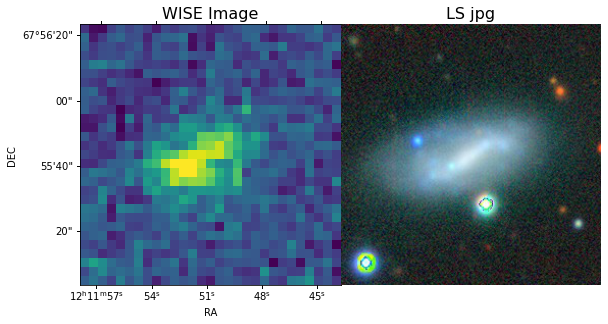

In [47]:
#test cell
for i in range(5,6):
    align_fits_snr_both('less',i,0.5)

In [ ]:
# "I don't know what that is. It looks like a crossword puzzle board." - My Mother